In [1]:
import os
import numpy as np
import random
import warnings

from xml.etree import ElementTree
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances
import mrcnn.model as modellib

# For data augmentation
from imgaug import augmenters as iaa

# Ignore the transparency warning since it really doesn't affect the training
warnings.filterwarnings("ignore", message=".*Palette images with Transparency.*")

# A. Dataset
The FoodDatasets class is designed to prepare the dataset for Mask R-CNN. It organizes the dataset into a format that the model can understand. 

## Loading Datasets
The load_dataset method scans the dataset directory for image and annotation files, separating them into training and validation sets. This split can be based on numeric image IDs or a random sampling strategy. It also parses the XML annotations to extract unique class names, which are registered using add_class. For each image, the add_image method is used to link the image path and corresponding annotation, ensuring the model can pair the data correctly during training or inference.

## Annotate Parsing
Annotations are managed using the `get_unique_classnames` and extract_boxes methods. The `get_unique_classnames` method reads all annotation files, extracts object classes, and creates a set of unique class names. These class names serve as the labels for object detection. The `extract_boxes` method, on the other hand, reads bounding box coordinates `(xmin, ymin, xmax, ymax)` and image dimensions (width and height) from XML files. These bounding boxes help the model localize objects within images. The `load_mask` method then creates binary masks for each detected object, associating each mask with its class ID. This is critical for the segmentation aspect of Mask R-CNN, allowing the model to predict pixel-level object boundaries.

In [2]:
#################################################
## DATASET
#################################################

class FoodDatasets(utils.Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        # Directories
        images_dir = os.path.join(dataset_dir, 'images')
        annots_dir = os.path.join(dataset_dir, 'annots')

        # Gather all annotation files
        annot_files = [
            os.path.join(annots_dir, f) for f in os.listdir(annots_dir)
            if f.lower().endswith('.xml')
        ]

        # Extract unique class names from all annotations
        gather_classnames = self.get_unique_classnames(annot_files)

        # Add classes
        for idx, class_name in enumerate(sorted(gather_classnames), start=1):
            print(f'idx: {idx} and name: {class_name}')
            self.add_class('dataset', idx, class_name)

        # Add images
        for annot_path in annot_files:
            filename = os.path.basename(annot_path)
            image_id = os.path.splitext(filename)[0]
            img_extensions = ('.png', '.jpg', '.jpeg')
            # Find corresponding image file
            for ext in img_extensions:
                img_filename = f"{image_id}{ext}"
                img_path = os.path.join(images_dir, img_filename)
                if os.path.exists(img_path):
                    break
            else:
                continue  # Skip if no image file found

            # Split the train and val based on image_id
            try:
                image_num = int(image_id)
            except ValueError:
                # If image_id is not an integer, decide on a split strategy
                # For example, use a hash or random split
                if is_train and random.random() > 0.2:
                    continue
                if not is_train and random.random() <= 0.2:
                    continue

            if is_train and image_num >= 7715:
                continue
            if not is_train and image_num < 7715:
                continue

            self.add_image(
                'dataset',
                image_id=image_id,
                path=img_path,
                annotation=annot_path
            )

    def get_unique_classnames(self, annot_files):
        class_names = set()
        for annot_file in annot_files:
            tree = ElementTree.parse(annot_file)
            root = tree.getroot()
            for obj in root.findall('.//object'):
                name = obj.find('name').text.strip()
                class_names.add(name)
        return class_names

    def extract_boxes(self, filename):
        tree = ElementTree.parse(filename)
        root = tree.getroot()

        # Extract each bounding box
        boxes = []
        for box in root.findall('.//object'):
            name = box.find('name').text.strip()
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            boxes.append([xmin, ymin, xmax, ymax, name])

        # Extract image dimensions
        size = root.find('.//size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        return boxes, width, height

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']

        # Load XML
        boxes, w, h = self.extract_boxes(path)
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = []
        for i, box in enumerate(boxes):
            xmin, ymin, xmax, ymax, class_name = box
            masks[ymin:ymax, xmin:xmax, i] = 1
            class_ids.append(self.class_names.index(class_name))

        return masks, np.array(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

#################################################
## CONFIGURATION
#################################################

class FoodConfig(Config):
    
    NAME = 'foods_cfg'
    NUM_CLASSES = 1 + 32
    IMAGES_PER_GPU = 2  # Adjust based on your GPU memory
    STEPS_PER_EPOCH = 300  # Increased for better training
    VALIDATION_STEPS = 50
    BACKBONE = 'resnet101'  # Using a deeper backbone
    # Anchor scales can be adjusted based on object sizes
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    TRAIN_ROIS_PER_IMAGE = 128
    MAX_GT_INSTANCES = 100
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640
    # Enable data augmentation
    USE_MINI_MASK = False
    MINI_MASK_SHAPE = (56, 56)

    # Data augmentation
    AUGMENTATION = iaa.SomeOf(
        (0, 3),
        [
            iaa.Fliplr(0.5),  # horizontal flips
            iaa.Flipud(0.5),  # vertical flips
            iaa.Affine(rotate=(-20, 20)),  # rotations
            iaa.Multiply((0.8, 1.2)),  # brightness
            iaa.GaussianBlur(sigma=(0, 1.0))  # blur
        ],
        random_order=True
    )

# Configuration
The `FoodConfig `class sets the configuration parameters for the Mask R-CNN model. It specifies the backbone network as `ResNet-101`, which provides a robust feature extraction mechanism pre-trained on the COCO dataset. The input image size is set to 640x640 to ensure uniformity across batches, improving training stability. 

Data augmentation techniques such as flipping, rotation, and brightness adjustments are applied to make the model more generalizable to real-world variations. Other parameters include `NUM_CLASSES`, which defines the number of unique food classes plus a background class, and `RPN_ANCHOR_SCALES`, which adjusts the size of region proposals based on object dimensions in the dataset.

In [3]:
#################################################
## TRAINING AND VALIDATION SETUP
#################################################

# Directory setup
ROOT_DIR = os.path.abspath('./')
LOGS_DIR = os.path.join(ROOT_DIR, 'logs')

# Create datasets
train_dataset = FoodDatasets()
train_dataset.load_dataset(dataset_dir='datasets', is_train=True)
train_dataset.prepare()

valid_dataset = FoodDatasets()
valid_dataset.load_dataset(dataset_dir='datasets', is_train=False)
valid_dataset.prepare()

# Configuration
config = FoodConfig()
config.display()

idx: 1 and name: -
idx: 2 and name: 18Friedegg
idx: 3 and name: Ayam
idx: 4 and name: Fried Rice
idx: 5 and name: Lalapan
idx: 6 and name: Sambal
idx: 7 and name: Tumis mie
idx: 8 and name: apple
idx: 9 and name: ayam-kentucky-dada
idx: 10 and name: ayam-kentucky-paha
idx: 11 and name: banana
idx: 12 and name: beef hamburger
idx: 13 and name: chicken-burger
idx: 14 and name: fried tofu
idx: 15 and name: indomie_goreng
idx: 16 and name: nasi_putih
idx: 17 and name: nugget
idx: 18 and name: omelet
idx: 19 and name: orange
idx: 20 and name: paha_ayam_goreng
idx: 21 and name: pisang
idx: 22 and name: rendang sapi
idx: 23 and name: rice
idx: 24 and name: sambal
idx: 25 and name: stir-fried kale
idx: 26 and name: tahu goreng
idx: 27 and name: tahu_goreng
idx: 28 and name: telur_dadar
idx: 29 and name: telur_rebus
idx: 30 and name: tempe goreng
idx: 31 and name: tempe_goreng
idx: 32 and name: tumis_kangkung
idx: 1 and name: -
idx: 2 and name: 18Friedegg
idx: 3 and name: Ayam
idx: 4 and name: 

Displaying image id of 3608


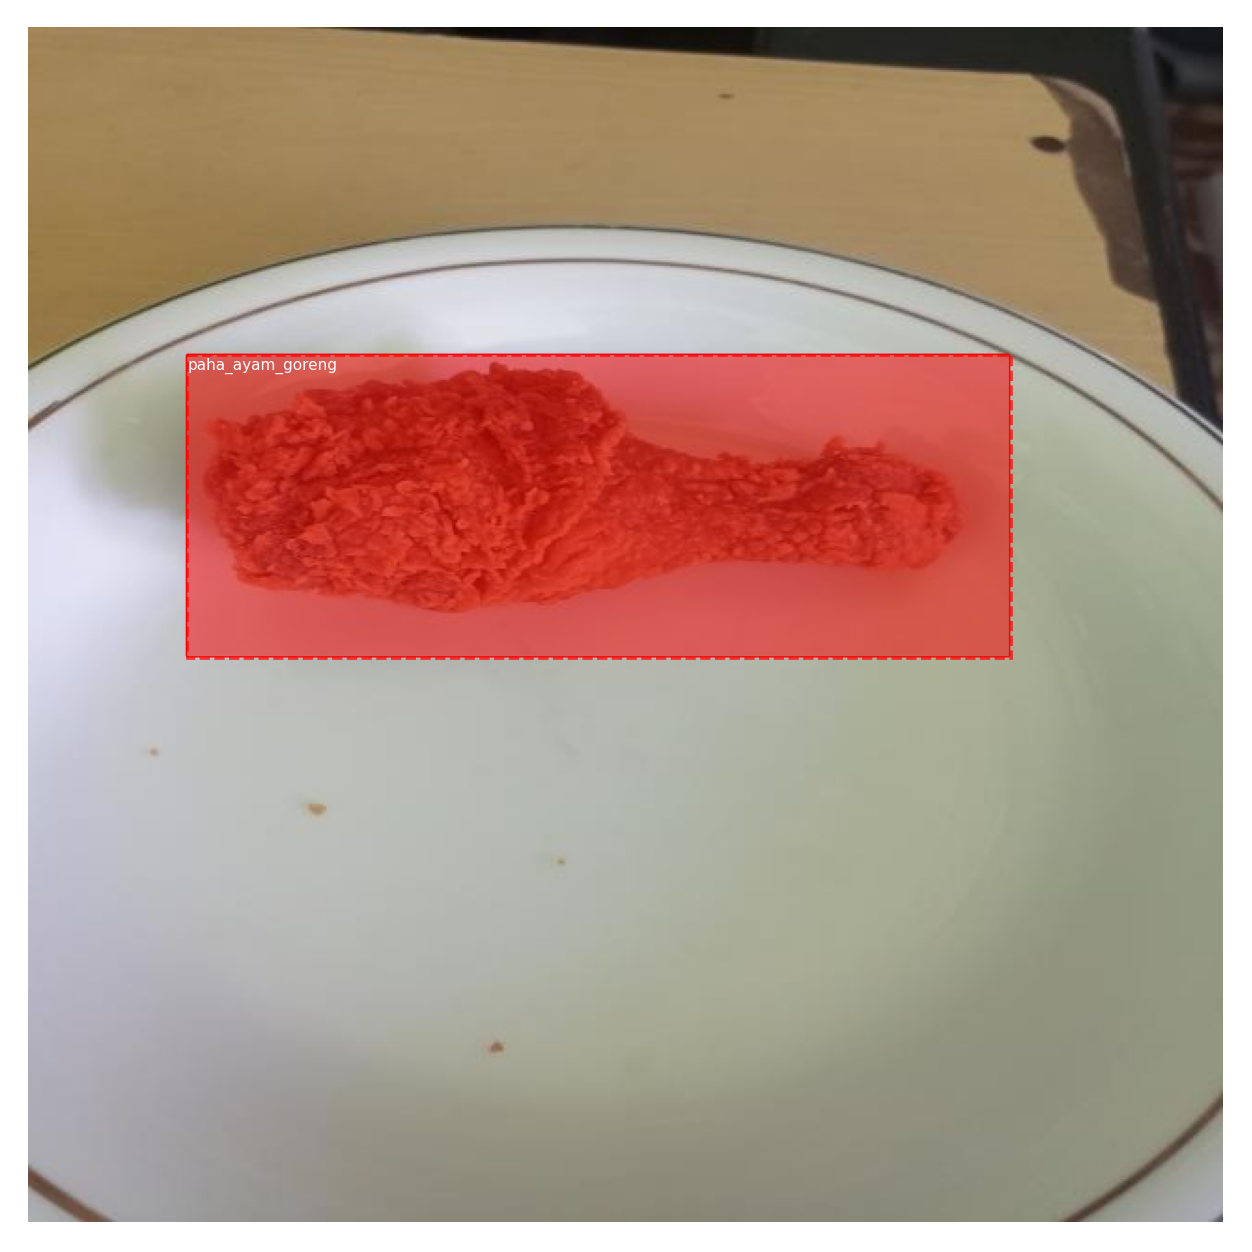

In [4]:
################# Exploring Dataset #################
# Not only exploring, but with this we can check which dataset is incorrect

num = random.randint(0, len(train_dataset.image_ids))
print(f'Displaying image id of {num}')
image_id = num
image = train_dataset.load_image(image_id)
mask, class_ids = train_dataset.load_mask(image_id)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_dataset.class_names)

# Exploring Dataset
By selecting random sample, we can see how each object is annotated. We can also verify if the annotation is correct already.

# B. Model
## Model Initialization
The Mask R-CNN model is initialized in training mode, which activates all components necessary for gradient updates. Pre-trained COCO weights are loaded into the model to provide a strong baseline. However, the COCO-specific layers such as mrcnn_class_logits, mrcnn_bbox, and mrcnn_mask are excluded to allow the model to focus on learning features specific to the food dataset. This transfer learning approach reduces training time significantly, leveraging the generalized feature extraction capabilities learned from COCO while adapting to the unique requirements of the food classification task.

## Training Phases
Training is divided into two stages. In the first stage, only the head layers of the model are trained while keeping the backbone frozen. This allows the newly added layers to learn features specific to the food dataset while retaining the generalized features learned from COCO. The learning rate and data augmentation are configured to ensure efficient learning. In the second stage, all layers are fine-tuned using a lower learning rate. This step refines the feature extraction capabilities of the backbone while aligning them with the food dataset’s specific patterns. Callbacks such as ReduceLROnPlateau and EarlyStopping are employed to optimize learning rates dynamically and prevent overfitting.

In [5]:

#################################################
## MODEL INITIALIZATION
#################################################

# Initialize Mask R-CNN model in training mode
model = modellib.MaskRCNN(mode='training', config=config, model_dir=LOGS_DIR)

# Load pre-trained weights (excluding the final layers)
COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)

model.load_weights(
    COCO_WEIGHTS_PATH,
    by_name=True,
    exclude=[
        "mrcnn_class_logits",
        "mrcnn_bbox_fc",
        "mrcnn_bbox",
        "mrcnn_mask"
    ]
)

#################################################
## TRAINING: STAGE 1 - Train Head Layers
#################################################

# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
]

# Start Stage 1 training
print("\n### Starting Stage 1: Training Head Layers ###\n")
model.train(
    train_dataset=train_dataset,
    val_dataset=valid_dataset,
    learning_rate=config.LEARNING_RATE,
    epochs=30,
    layers='heads',
    augmentation=config.AUGMENTATION,
    custom_callbacks=callbacks
)

#################################################
## TRAINING: STAGE 2 - Fine-Tune All Layers
#################################################

# Start Stage 2 training
print("\n### Starting Stage 2: Fine-Tuning All Layers ###\n")
model.train(
    train_dataset,
    valid_dataset,
    learning_rate=config.LEARNING_RATE / 10.0,
    epochs=60,
    layers='all',
    augmentation=config.AUGMENTATION,
    custom_callbacks=callbacks
)

model.keras_model.save_weights('logs/mrcnn_food_detection.h5')


### Starting Stage 1: Training Head Layers ###


Starting at epoch 0. LR=0.001

Checkpoint Path: d:\Projects\MachineLearning\CapstoneBangkit\mask_rcnn\logs\foods_cfg20241208T1534\mask_rcnn_foods_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4  

c:\ProgramData\miniconda3\envs\mrcnn_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\ProgramData\miniconda3\envs\mrcnn_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifi

300/300 [==============================] - ETA: 0s - batch: 149.5000 - size: 2.0000 - loss: 2.1226 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.7100 - mrcnn_class_loss: 0.4993 - mrcnn_bbox_loss: 0.5110 - mrcnn_mask_loss: 0.3740

c:\ProgramData\miniconda3\envs\mrcnn_env\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


300/300 [==============================] - 156s 457ms/step - batch: 149.5000 - size: 2.0000 - loss: 2.1226 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.7100 - mrcnn_class_loss: 0.4993 - mrcnn_bbox_loss: 0.5110 - mrcnn_mask_loss: 0.3740 - val_loss: 1.4509 - val_rpn_class_loss: 0.0189 - val_rpn_bbox_loss: 0.4008 - val_mrcnn_class_loss: 0.4021 - val_mrcnn_bbox_loss: 0.3790 - val_mrcnn_mask_loss: 0.2502
Epoch 2/30
300/300 [==============================] - 129s 430ms/step - batch: 149.5000 - size: 2.0000 - loss: 1.5005 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.4268 - mrcnn_class_loss: 0.4094 - mrcnn_bbox_loss: 0.3600 - mrcnn_mask_loss: 0.2835 - val_loss: 1.3700 - val_rpn_class_loss: 0.0141 - val_rpn_bbox_loss: 0.3780 - val_mrcnn_class_loss: 0.3710 - val_mrcnn_bbox_loss: 0.3476 - val_mrcnn_mask_loss: 0.2594
Epoch 3/30
300/300 [==============================] - 132s 439ms/step - batch: 149.5000 - size: 2.0000 - loss: 1.3129 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.3840 - mrcnn_class_loss

c:\ProgramData\miniconda3\envs\mrcnn_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\ProgramData\miniconda3\envs\mrcnn_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_alig

300/300 [==============================] - ETA: 0s - batch: 149.5000 - size: 2.0000 - loss: 1.5007 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1711 - mrcnn_class_loss: 0.1788 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.2255

c:\ProgramData\miniconda3\envs\mrcnn_env\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


300/300 [==============================] - 268s 809ms/step - batch: 149.5000 - size: 2.0000 - loss: 1.5007 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1711 - mrcnn_class_loss: 0.1788 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.2255 - val_loss: 1.5168 - val_rpn_class_loss: 0.0080 - val_rpn_bbox_loss: 0.1759 - val_mrcnn_class_loss: 0.2334 - val_mrcnn_bbox_loss: 0.1516 - val_mrcnn_mask_loss: 0.1895
Epoch 32/60
300/300 [==============================] - 243s 810ms/step - batch: 149.5000 - size: 2.0000 - loss: 1.6212 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.2209 - mrcnn_class_loss: 0.1832 - mrcnn_bbox_loss: 0.1635 - mrcnn_mask_loss: 0.2265 - val_loss: 1.5405 - val_rpn_class_loss: 0.0077 - val_rpn_bbox_loss: 0.1695 - val_mrcnn_class_loss: 0.2011 - val_mrcnn_bbox_loss: 0.1821 - val_mrcnn_mask_loss: 0.2098
Epoch 33/60
300/300 [==============================] - 241s 802ms/step - batch: 149.5000 - size: 2.0000 - loss: 1.5721 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2080 - mrcnn_class_lo